# Intro to DeConvNet

One prolonged question we've been curious to investigate is if there is a way to take the output classifications from a CNN and backpropogate to figure out what the NN sees in this classification by almost passing an image backwards through the model. After previously questioning this, we covered the methods in class for DeConvNet/ visualizing and understanding classifications, and now in this notebook we will implementing some concepts. 


## The general concept

Thus far in our implementations, we have been designing models by pooling the data at each hidden layer to filter and map the data into deeper and re-sized layers. With our familiar MaxPooling for example, we are taking the max of a rectified feature and mapping it (pooling it) to the next layer, but this means that this operation cannot be reversed. In other words, there is no way to know or reconstruct the exact high-resolution data of the pre-pooled layer just by knowing the max-pooled value. However, here we have found and implemented tensorflow's Conv2DTranspose function (a DeConvNet function) to perform the "unpooling" that will result in a lower resolution renduring of the input image, which could be thought of as almost the skeleton of the most important and identifiable components of the image, or an out of focus (less detailed) image.

## Use Cases

Following recent papers and documentation, we have stumbled on multiple use cases where the ability to perform this DeConvNet is important. 

1. Simply Visualizing the "hidden" layers of your NN: As we know with any other category of programming having polished debugging techniques and tools is extremely important for efficient development. Having the ability to visualize and reconstruct layers of a NN model will help us interpret and analyze what is actually going on layer to layer. So, instead of looking for an error, using DeConvNet will help us dive into the model and identify where we can improve accuracies.

2. Noise Defense/Management: Pooling and then unpooling an image returns an image that resembles the most important components of the origional image, but is at a lower resolution. In some cases (for example, we found use cases for very noisy image datasets or datasets that are too large and need to be compressed) reducing the resolution can actually help simplify the categorization of the image by reducing the data to its "skeleton" before interpreting it. In our one pixel attack investigation, we looked into how we could add noise strategically to sabatage a classification. This denoising technique could be implemented as a "counter-attack" (maybe more-so in future weeks) as we could likely classify the image after pooling and unpooling and then re-classifying the lower resolution image. 


3. Object Localizaiton: With self-driving cars and other autonomous vision softwares being a hot topic with todays tech, identifying an object and localizing it is a common task. Using the simplicity that results from DeConvNet, forming a feature map of an image and process through backward pass allows us to identify an object (likely with a probability/confidence) in a random location within the image.

### Conv2DTranspose

Conv2DTranspose is the DeConvNet function commonly used within tensorflow.keras. Since we are attempting to now go from something with the shape of the output of a convolution to something that has the shape of the input, we need the "transpose" the process (in the context of linear operation). This is implemented on a couple cifar10 images below. In the outputs we can see what survived the pooling steps of the propogation and what needs to be imposed to complete the low-resolution recovery of the image.

While outputing two cases of our first implementaiton of conv2Dtranspose, we also have messed with the weighting of the model to demonstrate how that will impact the resolution of our unpooled result that stemmed from the origional classified photo.

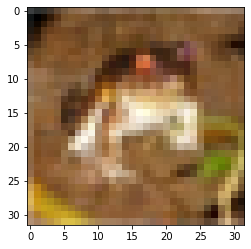

(32, 32, 3)
(1, 32, 32, 3)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_20 (Conv2DT (None, 64, 64, 1)         4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


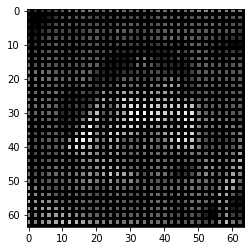

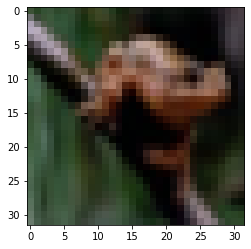

(32, 32, 3)
(1, 32, 32, 3)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_21 (Conv2DT (None, 64, 64, 1)         4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


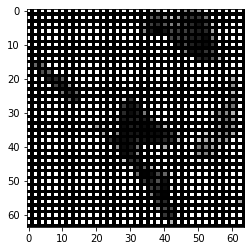

In [ ]:
from numpy import asarray
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2DTranspose
import numpy as np
from PIL import Image
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf


(X_train, Y_train), (testX, Y_test) = cifar10.load_data()
image=X_train[0,:,:,:] #choosing random image to use
plt.imshow(image)
plt.show()

print(image.shape)
image=image.reshape((1, 32,32, 3))
print(image.shape)

model = Sequential()
model.add(Conv2DTranspose(1,(1,1), strides=(2,2), padding='same', input_shape=(32,32,3))) #transpose deconvnet ************
model.summary()
weights=[np.array([[[[ 0, 1, 0 ]]]]), np.array([0])]
model.set_weights(weights)

est = model.predict(image)
#print(est.shape)
est = est.reshape((64, 64))
data = Image.fromarray(est)
#print(est)
if(data.mode!='RGB'):
    data=data.convert('RGB')    

plt.imshow(data)
plt.show()





'''Doing it again for another image and new weights'''





image=X_train[5000,:,:,:] #choosing random image to use
plt.imshow(image)
plt.show()

print(image.shape)
image=image.reshape((1, 32,32, 3))
print(image.shape)

model = Sequential()
model.add(Conv2DTranspose(1,(1,1), strides=(2,2), padding='same', input_shape=(32,32,3))) #transpose deconvnet ***************
model.summary()
weights=[np.array([[[[ 10, 1, 10 ]]]]), np.array([0])]
model.set_weights(weights)

est = model.predict(image)
#print(est.shape)
est = est.reshape((64, 64))
data = Image.fromarray(est)
#print(est)
if(data.mode!='RGB'):
    data=data.convert('RGB')    

plt.imshow(data)
plt.show()




The checkered looking images give us a somewhat clear idea what is "going missing" as we try to recover these images after one or more pooling events. There are clear gaps and missing data in these images. We also notice that when we add higher weights to the model, the less information we are able to recover since the recoverable data (between the black gaps) is all "whiter" ie all of less distinguishable values. To make this deconvnet effective, we need to perform a similar process, but additionally fill in an reconstructed approximation for the missing data in the image as well. See below.

### Reconstruction
After performing the sigle line call of a DeConvNet, we can now investigate what the NN sees in our image when we put the origional image through multiple hidden layers, and then reconstruct the image backwards until we have a low resolution representation of the origional. In the below example, we train through 25 epochs and then reconstruct back through the 3 hidden layers using tensorflows Conv2D function again. The resulting image is the lower resolution interpretaiton of the origional image.


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 26, 26, 16)        4624      
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 28, 28, 16)        2320      
_________________________________________________________________
conv2d_transpose_23 (Conv2DT (None, 30, 30, 32)        4640      
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 3)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


1/1 [==============================] - 1s 696ms/step - loss: 0.6926
Epoch 2/25
1/1 [==============================] - 0s 11ms/step - loss: 0.6871
Epoch 3/25
1/1 [==============================] - 0s 14ms/step - loss: 0.6778
Epoch 4/25
1/1 [==============================] - 0s 13ms/step - loss: 0.6635
Epoch 5/25
1/1 [==============================] - 0s 8ms/step - loss: 0.6426
Epoch 6/25
1/1 [==============================] - 0s 14ms/step - loss: 0.6156
Epoch 7/25
1/1 [==============================] - 0s 10ms/step - loss: 0.5903
Epoch 8/25
1/1 [==============================] - 0s 12ms/step - loss: 0.5914
Epoch 9/25
1/1 [==============================] - 0s 7ms/step - loss: 0.5994
Epoch 10/25
1/1 [==============================] - 0s 12ms/step - loss: 0.5860
Epoch 11/25
1/1 [==============================] - 0s 12ms/step - loss: 0.5692
Epoch 12/25
1/1 [==============================] - 0s 9ms/step - loss: 0.5598
Epoch 13/25
1/1 [==============================] - 0s 12ms/step - loss: 0.

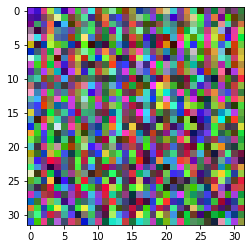

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

# Model configuration
batch_size = 1
no_epochs = 25
(X_train, Y_train), (testX, Y_test) = cifar10.load_data()
image=X_train[5000,:,:,:] #choosing random image to use
x=X_train[5000,:,:,:] #choosing random image to use
image = image.reshape(1, 32, 32, 3).astype('float32')
image/= 255.0
input_shape=image.shape

model = Sequential() #make quick model with 3 hidden layers down and then coming back
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32,3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(Conv2DTranspose(16, kernel_size=(3,3), activation='relu'))
model.add(Conv2DTranspose(32, kernel_size=(3,3), activation='relu'))
model.add(Conv2DTranspose(64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same'))


model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy')
model.fit(image, image,epochs=no_epochs,batch_size=batch_size)
reconstructions = model.predict(image)
predicted_img = Image.fromarray(reconstructions.reshape(32,32,3), 'RGB')
plt.imshow(predicted_img)
plt.show()


As you can see in the summary, this simple model uses 3 conv2D calls to iterate down 3 hidden layers until the image shape went from 32,32,3 to 26, 26, 16. Then using conv2dtranspose, we reverse the direction of these transformations from 26,26,16 ro 32,32,3 with padding of 'same' to fill the gaps that we whitnessed in the previous section. The resulting image is the RBG representation of the reconstructed image at lower resolution. This is hard for us to distinguish and we believe this is because our origional model was made with very little effort (no batch normalizations, dropouts, etc). To make this we followed a tutorial where they did something similar with a kangaroo image and when we run the tutorial we get something similar, so we are lead to believe this is no error. In two sections from now we develop our model with much more care to see if our output reconstructions are recognizable to us humans at their lower resolution.

### Visualizing intermediate layers (for "debugging" accuracy of model)

The above outputed image of the lower resolution interpretation after performing multiple foreward and multiple backward hidden layers and is curious. One way to debug and investigate the intermediate layers that the model performed, is to visualize each abstract feature of each of the layers. This has been implemented and outputted for the 3 conv2D and 3 conv2DTranspose layers that we also performed on ConvD10 in the above section. The layer of each feature is listed above the image. 

['conv2d_24', 'conv2d_25', 'conv2d_26', 'conv2d_transpose_22', 'conv2d_transpose_23', 'conv2d_transpose_24', 'conv2d_27']
[<keras.layers.convolutional.Conv2D object at 0x7f2d7d0e6490>, <keras.layers.convolutional.Conv2D object at 0x7f2d7d0e63d0>, <keras.layers.convolutional.Conv2D object at 0x7f2e702a38d0>, <keras.layers.convolutional.Conv2DTranspose object at 0x7f2d8670c790>, <keras.layers.convolutional.Conv2DTranspose object at 0x7f2d7ad484d0>, <keras.layers.convolutional.Conv2DTranspose object at 0x7f2e7011fd10>, <keras.layers.convolutional.Conv2D object at 0x7f2e7011ff90>]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


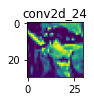

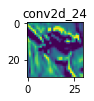

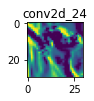

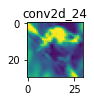

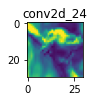

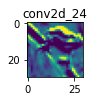

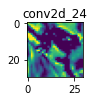

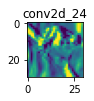

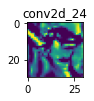

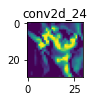

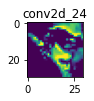

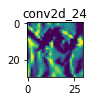

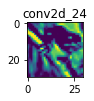

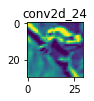

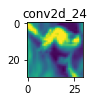

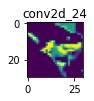

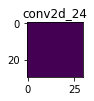

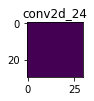

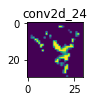

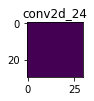

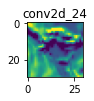

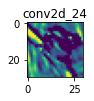

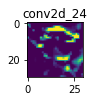

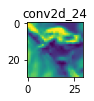

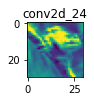

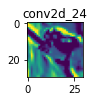

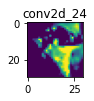

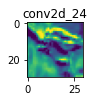

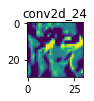

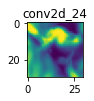

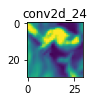

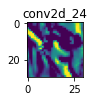

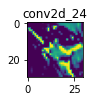

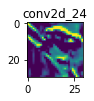

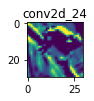

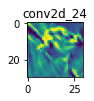

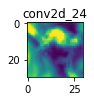

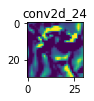

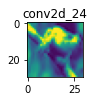

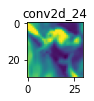

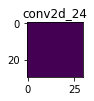

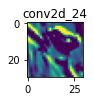

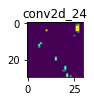

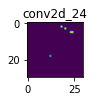

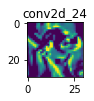

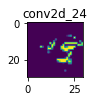

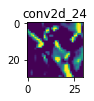

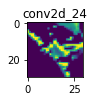

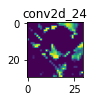

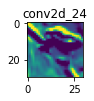

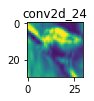

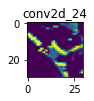

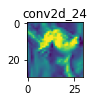

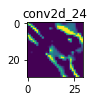

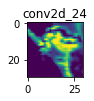

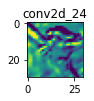

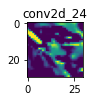

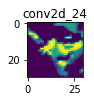

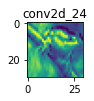

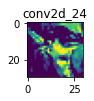

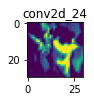

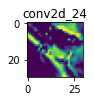

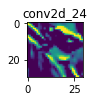

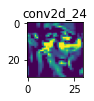

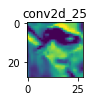

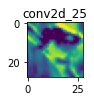

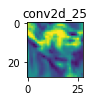

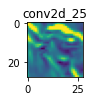

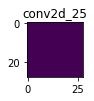

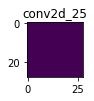

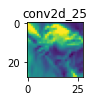

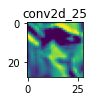

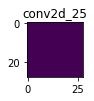

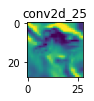

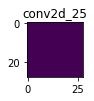

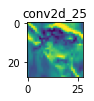

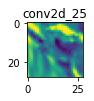

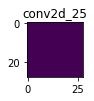

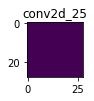

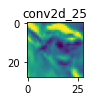

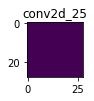

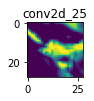

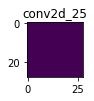

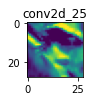

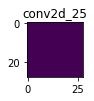

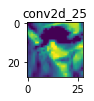

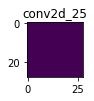

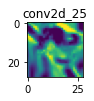

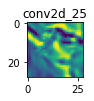

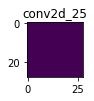

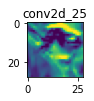

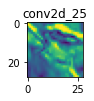

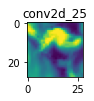

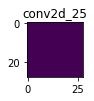

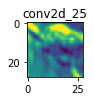

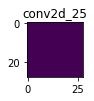

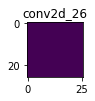

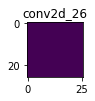

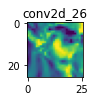

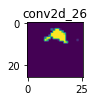

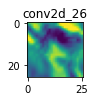

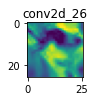

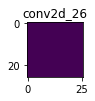

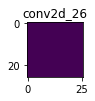

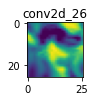

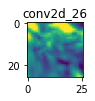

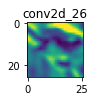

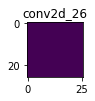

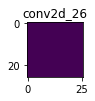

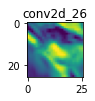

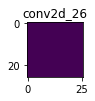

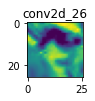

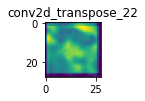

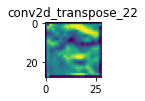

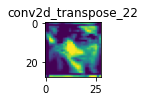

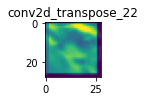

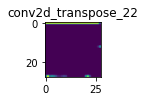

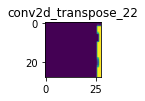

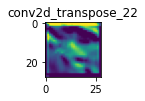

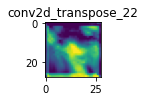

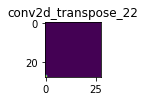

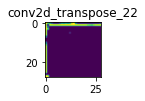

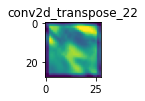

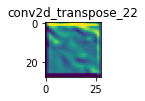

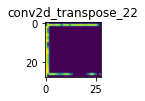

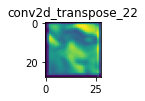

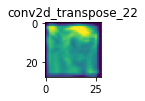

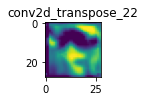

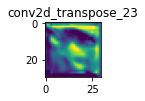

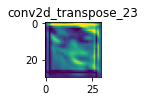

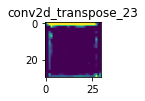

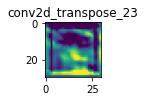

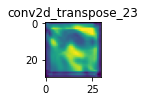

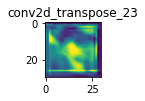

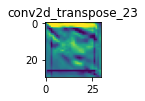

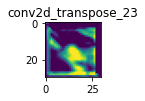

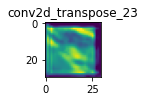

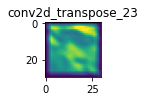

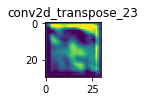

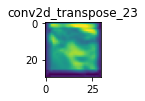

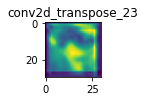

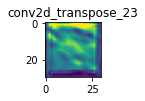

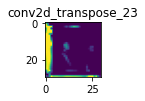

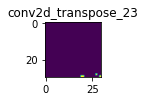

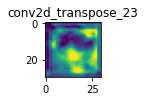

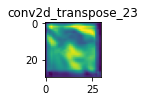

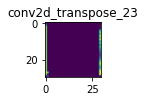

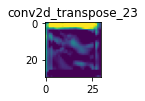

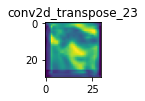

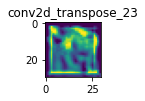

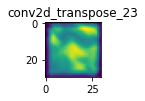

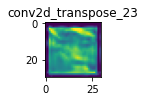

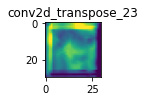

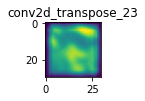

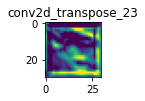

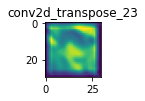

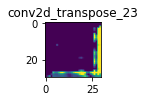

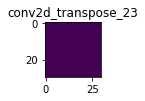

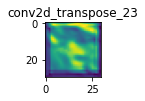

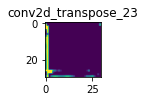

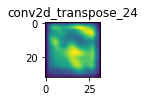

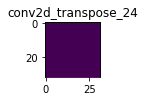

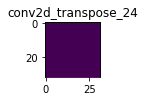

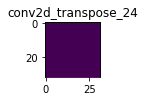

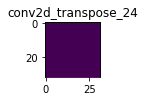

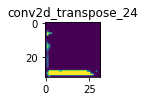

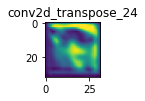

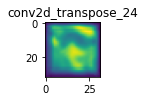

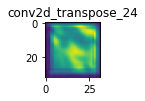

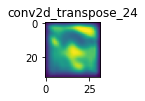

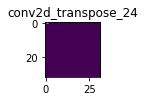

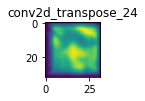

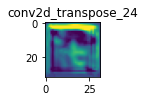

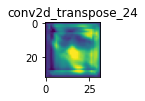

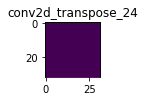

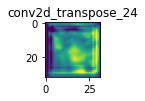

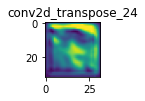

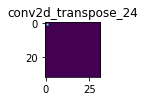

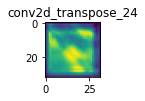

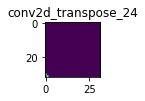

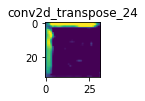

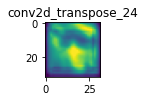

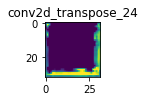

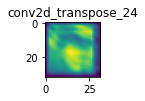

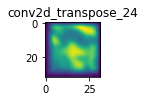

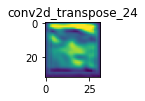

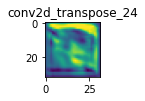

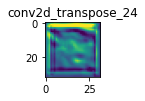

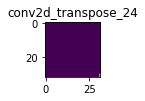

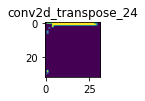

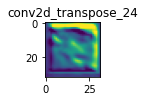

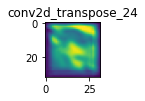

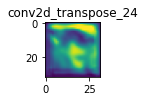

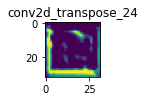

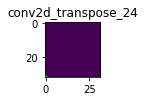

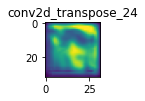

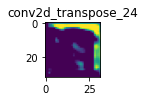

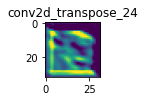

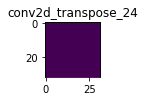

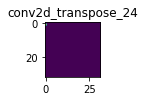

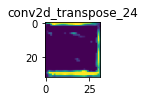

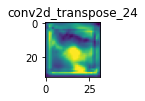

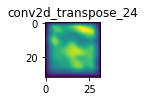

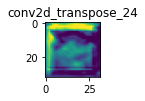

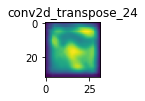

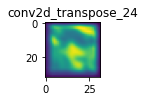

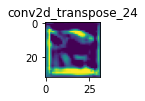

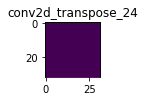

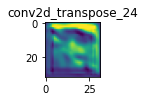

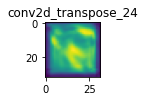

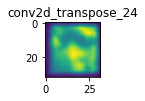

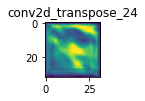

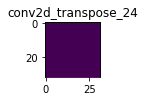

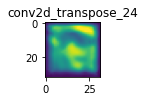

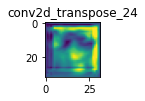

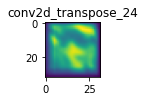

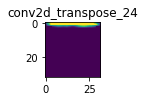

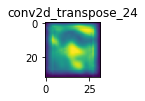

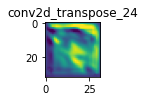

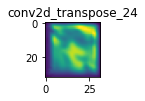

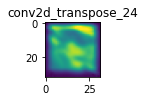

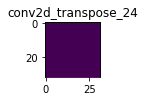

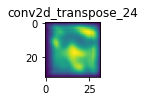

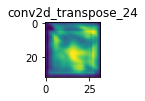

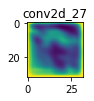

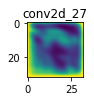

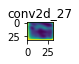

In [ ]:
import tensorflow as tf
layer_names = [layer.name for layer in model.layers]
print(layer_names) #see all layers
print(model.layers) #locations
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = tf.keras.Model(inputs=model.inputs, outputs=layer_outputs)
feature_maps = feature_map_model.predict(image)
for layer_name, feature_map in zip(layer_names, feature_maps):  
  if len(feature_map.shape) == 4:
      k = feature_map.shape[-1]  
      size=feature_map.shape[1]
      for i in range(k):
        feature_image = feature_map[0, :, :, i]
        feature_image-= feature_image.mean()
        feature_image/= feature_image.std ()
        feature_image*=  64
        feature_image+= 128
        feature_image= np.clip(feature_image, 0, 255).astype('uint8')
        image_belt = feature_image[0:30,:]  
        scale = 20. / k
        plt.figure( figsize=(1,1) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( feature_image, aspect='auto')

plt.tight_layout()

Each of these small images is one of the filters being applied at the hidden layer that is specified above the image. If you were to count, there would be 64 filters of conv2d, 32 filters of conv2d_1, 16 conv2d_2 filters, 16 conv2d_transpose_2 filters , 32 conv2d_transpose_3 filters, 64 conv2d_transpose_4 filters, and 3 conv2d_3 filters. Ie, we are looking at what the computer is interpreting in each of the hidden layers! These images also look similar to what is alluded to in the slide that covers the paper "visualizing and understanding convolutional networks".

## Noise Defense/ Management

After the previous introduction to deconvnet and visualizations, we will now put these into a more applied instance of performing categorization with noisey images. This runs very parallel with parts of our work with an adverserial example using fast gradient sign method in our robustness file. Adding noise to an image can, by definition, can confuse our model enough to mis-classify and/or reduce confidence in a classification. In this section we are using our previously demonstrated deconvnet technique to return a lower-resolution image that still maintains the most characteristic components of the image, which effectively reduces the impact of noise or attacked pixels in the image. We first performed this with the cifar10 data set since that is what we have been working with so far in this notebook, then we were curious to see how it would perform on a more black-and-white dataset, so we performed it again on mnist.

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, MaxPool2D, UpSampling2D
from tensorflow.keras.datasets import mnist, cifar10

%matplotlib inline

### Cifar10

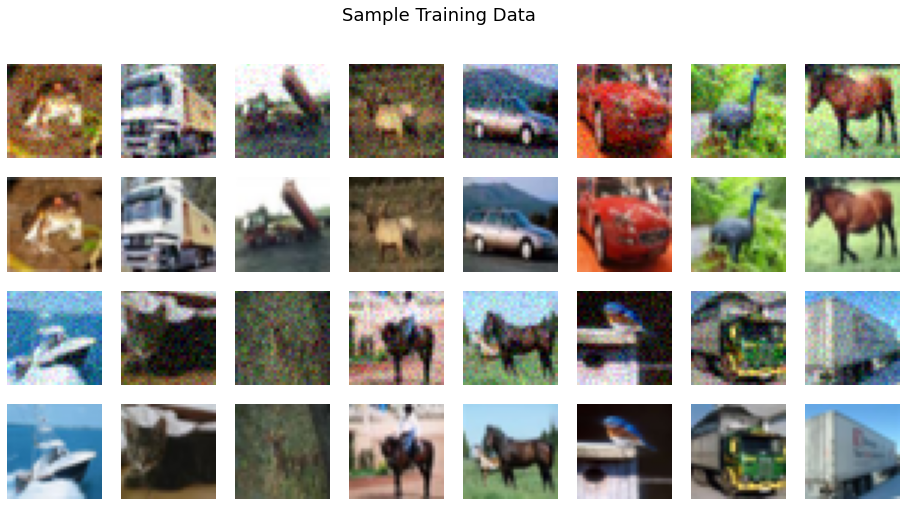

In [ ]:
(X_train, _), (X_test, _) = cifar10.load_data()

size = 32
channel = 3
X_train = X_train / 255
X_test = X_test / 255

# Adding random noise with mean = 0 and std dev = 0.25
noise = 0.25
X_train_noise = X_train + noise * np.random.normal(0, 0.25, size=X_train.shape) 
X_test_noise = X_test + noise * np.random.normal(0, 0.25, size=X_test.shape)

X_train_noise = np.clip(X_train_noise, 0, 1)
X_test_noise = np.clip(X_test_noise, 0, 1)


# Visualize few training images with their noisy images

rows = 2 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(X_train_noise[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(X_train[i*cols + j]) 
        plt.axis("off")
        
f.suptitle("Sample Training Data",fontsize=18)

plt.show()

Above we have quickly outputted some of the cifar10 images side-by-side to their noisey version that we are trying to mitigate. As we saw in our previous notebook on the adverserial example, it is possible (and actually likely) to highly impact the classification of an image by not even adding enough noise for our human eyes to notice. As we can see above, adding 0.25 noise is very visible and therefore would have a large impact on the classification ability of our model. 

Below we go through a similar process that we have previously where we use Conv2D (foreward) to make a couple hidden layers, and then Conv2DTranspose to reconstruct the image. After further research we realized this is often referred to and broken up as encoding and decoding the model, thus we implemented it as such. We also included more detailed model development with dropout, batch normalization, etc. 

In [ ]:
# Encoder 
inputs = Input(shape=(size,size,channel))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
x = tf.keras.layers.LeakyReLU()(skip)
x = tf.keras.layers.BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
encoded = MaxPool2D()(x)

# Decoder
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = tf.keras.layers.add([x,skip]) # adding skip connection
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder = tf.keras.Model(inputs, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy')
autoencoder.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 32, 32, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 32, 32, 32)   128         conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 16, 16, 32)   0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


After developing our encoded and decoded model above (see summary for details), we will train the data and investigate how the model performs with the validation noisey image data. If we can minimize our loss function to a reasonably low value and not overfit, we will be successful!

Epoch 1/25
196/196 [==============================] - 11s 48ms/step - loss: 0.5759 - val_loss: 0.6161
Epoch 2/25
196/196 [==============================] - 9s 44ms/step - loss: 0.5606 - val_loss: 0.5801
Epoch 3/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5589 - val_loss: 0.5635
Epoch 4/25
196/196 [==============================] - 9s 44ms/step - loss: 0.5581 - val_loss: 0.5587
Epoch 5/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5576 - val_loss: 0.5555
Epoch 6/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5571 - val_loss: 0.5556
Epoch 7/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5569 - val_loss: 0.5550
Epoch 8/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5567 - val_loss: 0.5548
Epoch 9/25
196/196 [==============================] - 9s 45ms/step - loss: 0.5565 - val_loss: 0.5565
Epoch 10/25
196/196 [==============================] - 9s 44ms/step - loss: 0.5564 - val_l

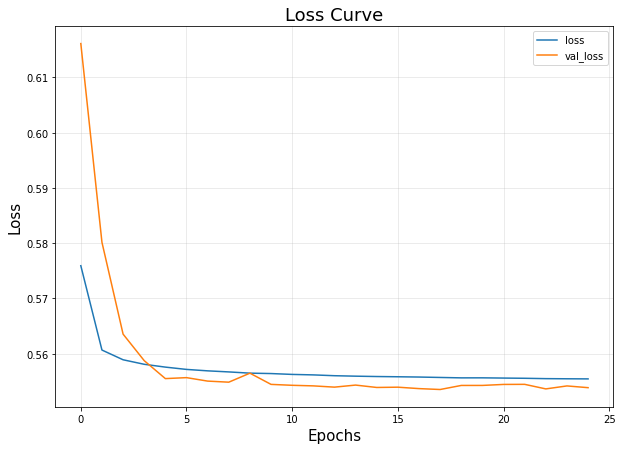

In [ ]:
# Training
epochs = 25
batch_size = 256
history = autoencoder.fit(X_train_noise,
                X_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test_noise, X_test)
               )

# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()


From the figure above, we can see that our loss has fallen to a low value, suggesting high accuracy of classification for both our training and validation set, so we have shown success in eliminating the impacts of noise in attacking our classification model. 

Below we will visualize the noisy versus recovered images to finalize our understanding of why this worked.

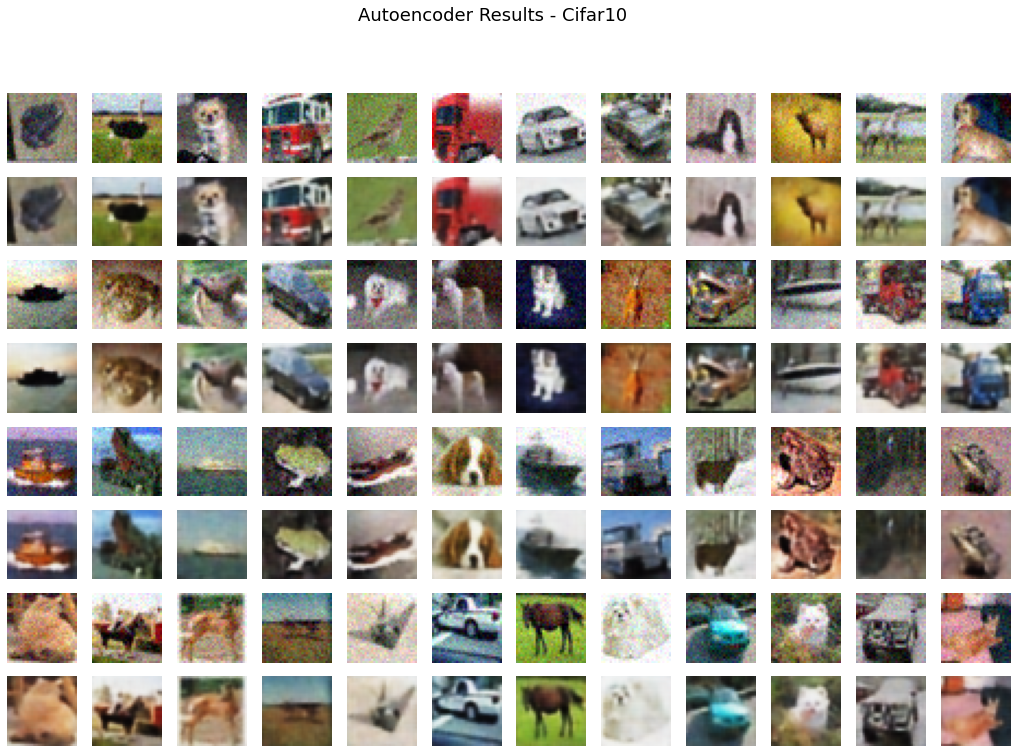

In [ ]:
# Select few random test images
num_imgs = 48
rand = np.random.randint(1, X_test_noise.shape[0]-48) 

X_test_images = X_test_noise[rand:rand+num_imgs] # slicing
X_test_desoided = autoencoder.predict(X_test_images) # predict

# Visualize test images with their denoised images

rows = 4 # defining no. of rows in figure
cols = 12 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure 
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(X_test_images[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(X_test_desoided[i*cols + j]) 
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)


plt.show()

The images above show us the "before and after" of managing a noisey image with a encoded and decoded (aka autoencoded) model with deconvNet. The image goes from high resolution and noisey to low resolution with none to very little noise. As a human identifying these images, many of them are more identifiable after after this transformation such as the fox. 

### Same thing with Mnist data

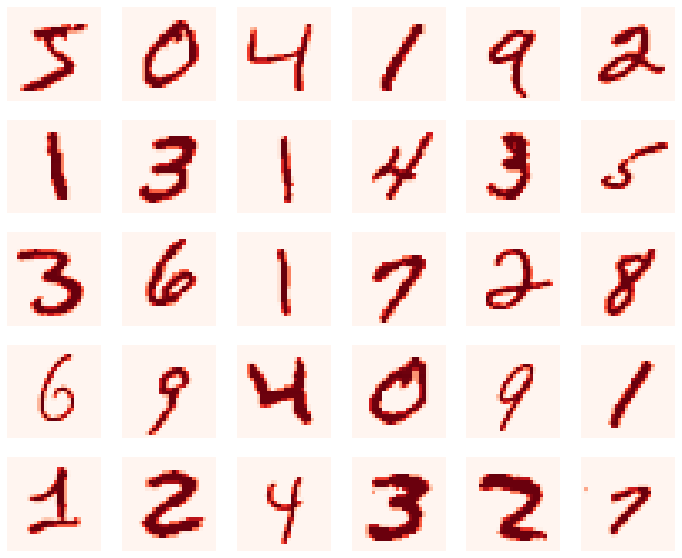

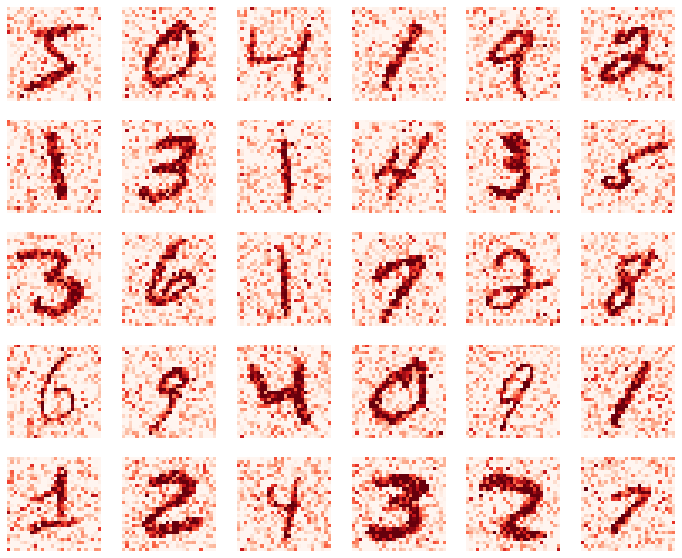

In [ ]:

(train, _), (test, _) = mnist.load_data()

# scaling input data
train = train.reshape([-1,28,28,1]) / 255
test = test.reshape([-1,28,28,1]) / 255

# Adding noise to data
noise = 0.3
train_noise = train + noise * np.random.normal(0, 1, size=train.shape)
test_noise = test + noise * np.random.normal(0, 1, size=test.shape)

train_noise = np.clip(train_noise, 0, 1)
test_noise = np.clip(test_noise, 0, 1)

# sample original image

rows = 5 # defining no. of rows in figure
cols = 6 # defining no. of colums in figure
subplot_size = 2
f = plt.figure(figsize=(subplot_size*cols, subplot_size*rows)) # defining a figure 

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.imshow(train[i].reshape([28,28]),cmap="Reds") 
    plt.axis("off")
plt.show()


# sample noisy image

rows = 5 # defining no. of rows in figure
cols = 6 # defining no. of colums in figure
subplot_size = 2

f = plt.figure(figsize=(subplot_size*cols,subplot_size*rows)) # defining a figure 

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1) # adding sub plot to figure on each iteration
    plt.imshow(train_noise[i].reshape([28,28]),cmap="Reds") 
    plt.axis("off")
plt.show()



Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 7, 32)          9248

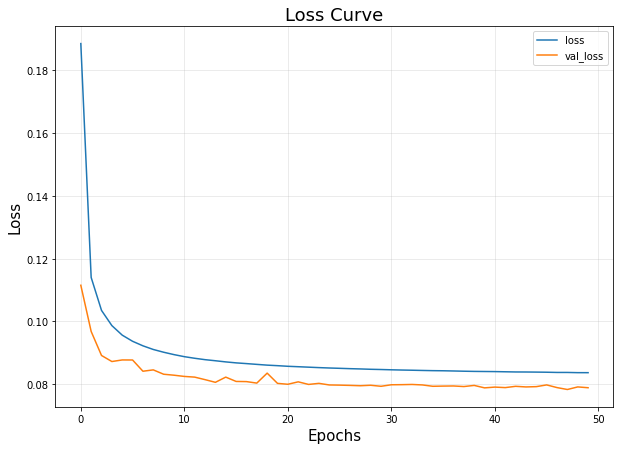

In [ ]:

# Encoder 
inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPool2D()(x)
x = Dropout(0.3)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
encoded = MaxPool2D()(x)

# Decoder

x = Conv2D(32, 3, activation='relu', padding='same')(encoded)
x = UpSampling2D()(x)
x = Dropout(0.3)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(inputs, decoded)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

autoencoder.summary()

epochs = 50
batch_size = 256

history = autoencoder.fit(train_noise,
                train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_noise, test)
               )


# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.show()



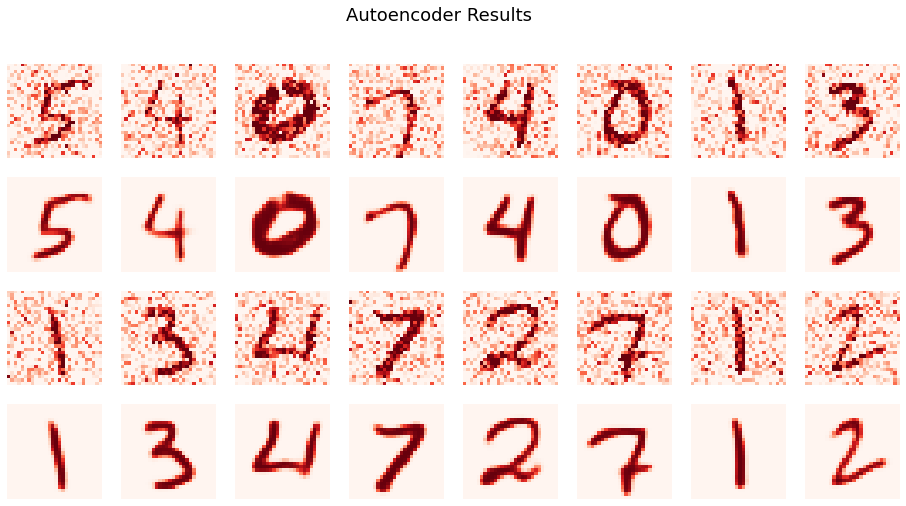

In [ ]:

# Select few random test images
num_imgs = 16
rand = np.random.randint(1, 100)

test_images = test_noise[rand:rand+num_imgs] # slicing
test_desoided = autoencoder.predict(test_images) # predict
# Visualize test images with their denoised images

rows = 2 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_images[i*cols + j].reshape([28,28]),cmap="Reds") 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(test_desoided[i*cols + j].reshape([28,28]),cmap="Reds") 
        plt.axis("off")
        
f.suptitle("Autoencoder Results",fontsize=18)
plt.savefig("test_results.png")

plt.show()

This method has worked particularly well with the mnist data with losses dropping below 0.1. As seen in the above comparison between the noisey inputs and the low-resolution results, the autoencoding method worked very well due to the binary nature of the mnist data. With a binary image, pooling down multiple hidden layers maintains far more information of from the image as we reconstruct the image and fill the padding with "same". Thus we can conclude that using autoencoding as a noise defense method is extremely effective for maintaining accurate classification of image data.

In future weeks we will likely chose to investigate further using these concepts to perform object localization and heat mapping, however this week we "ran out of GPU" on colab and thus did not have time to implement. One cite that we were in the middle of reading closely and implementing was https://www.machinecurve.com/index.php/2019/11/28/visualizing-keras-cnn-attention-grad-cam-class-activation-maps/ however, without the gpu we didn't have time to carry out our own implementation and it obviously wasn't worth putting that code in here when you can just follow the link if your interested.

## Other Visited links 
https://github.com/fabianbormann/Tensorflow-DeconvNet-Segmentation/blob/master/DeconvNet.py
https://github.com/maziarraissi/Applied-Deep-Learning/blob/main/01%20-%20Computer%20Vision/01%20-%20Image%20Classification/05%20-%20Visualizing%20%26%20Understanding.pdf
https://medium.com/analytics-vidhya/a-complete-guide-for-visualising-and-understanding-convolutional-networks-dc26f71c979f
https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
https://gigadom.in/2020/04/18/deconstructing-convolutional-neural-networks-with-tensorflow-and-keras/
https://mydeeplearningnb.wordpress.com/2019/07/24/visualizing-cnns-using-tensorflow/
https://www.kaggle.com/tarunkr/autoencoder-denoising-image-mnist-cifar10
